In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import pandas as pd
import glob as glob

OUT_PATH = "outs_final_nee"
os.makedirs(OUT_PATH, exist_ok=True)

DATA_PATH = "ny/afv/prelim/20210101_SWAPS"


ONE_COL_MM = 890 * 2/3

nee_fs = 7
font = {
    "family": "sans-serif",
    "sans-serif": ["Helvetica"],
    "weight": "normal",
    "size": nee_fs,
}
plt.matplotlib.rc("font", **font)

In [2]:

prefixes = {
    "HP3x3x3s":f"{DATA_PATH}/HP3x3x3s/",
    "HP5x5s":f"{DATA_PATH}/HP5x5s/",
    "RNA12":f"{DATA_PATH}/RNA12",
    "s_2_8":f"{DATA_PATH}/s_2_8"   
}

labels = {
    "HP3x3x3s":"HP3x3x3",
    "HP5x5s":"HP5x5",
    "RNA12":"RNA12",
    "s_2_8":r"$S_{2,8}$"   
}

sizes = {
    "HP3x3x3s":2**27,
    "HP5x5s":2**25,
    "RNA12":4**12,
    "s_2_8":8**8 
}

lengths = {
    "HP3x3x3s":27,
    "HP5x5s":25,
    "RNA12":12,
    "s_2_8": 8 
}


linspaces = {
    "HP3x3x3s":np.linspace(0,2**27,101).astype(int),
    "HP5x5s":np.linspace(0,2**25,101).astype(int),
    "RNA12":np.linspace(0,4**12,101).astype(int),
    "s_2_8":np.linspace(0,8**8,101).astype(int),
}
colors  = ['#9e0142','#d53e4f','#f46d43','#fdae61','#fee08b','#e6f598','#abdda4','#66c2a5','#3288bd','#5e4fa2']
colors[1] ="C0"
colors[2] ="C1"
colors[3] ="C2"
colors_map = {}
colors_map["HP_3x3x3s"] = colors[1]
colors_map["HP3x3x3s"] = colors[1]
colors_map["HP_5x5s"] = colors[3]
colors_map["HP5x5s"] = colors[3]
colors_map["s_2_8"] = colors[0]
colors_map["RNA_12"] = colors[2]
colors_map["RNA12"] = colors[2]

In [3]:
pheno_dict = {
    0:"phenotype",
    1:"n_components",
    2:"Frequency", # volume_0
    3:"surface_0", # Sum of component surfaces
    4:"volume_1", # ( f_p * (K-1) * L * r_p )/(double)2
    5:"surface_1",
    6:"robustness",
    7:"evolvability_wagner",
    8:"evolvability_cowperthwaite",
    9:"evolvability_wagner_nond",
    10:"evolvability_cowperthwaite_nond",
    11:"S_1", # f_p * (1 - r_p)
    12:"S_2", # S_1 = V_1 * 2(1/r_p - 1)
    13:"surface_unique"
}

In [4]:
threshold = 1e7
dfs = []
for prefix_key, prefix in prefixes.items():
    files = [file for file in glob.glob(os.path.join(prefix, "stats*.txt")) if "swaps" not in file]
    for file in files:
        swap_index = int(re.findall("s(\d+).txt", file)[0])
        swaps = linspaces[prefix_key][swap_index]
        df = pd.read_csv(file, sep="\t")
        df_pheno = pd.read_csv(file.replace(f"stats{swap_index}.txt", f"NC/phenotype_stats{swap_index}.txt"), sep="\t", header=None, names=pheno_dict.values())
        df["u+v"] = df["u_size"] + df["v_size"]
        df["threshold"] = (df["u+v"] > threshold)*1
        df["freq_mean"] = (df_pheno["Frequency"]/sizes["HP5x5s"]).mean()
        df["rob_mean"] = (df_pheno["robustness"]).mean()
        df["freq_std"] = (df_pheno["Frequency"]/sizes["HP5x5s"]).std()
        df["rob_std"] = (df_pheno["robustness"]).std()
        df["rob-freq-ratio_mean"] = ((df_pheno["robustness"])/(df_pheno["Frequency"]/sizes["HP5x5s"])).mean()
        df["rob-freq-ratio_std"] = ((df_pheno["robustness"])/(df_pheno["Frequency"]/sizes["HP5x5s"])).std()
        df["swap_index"] = swap_index
        df["swaps"] = linspaces[prefix_key][swap_index]
        df["swaps_prop"] = df["swaps"]/sizes[prefix_key]
        df["GP map"] = prefix_key
        dfs.append(df)
    
dfs = pd.concat(dfs).reset_index(drop=True)

# Only keep non-aborted
dfs = dfs[dfs["threshold"]==0]

# Robustness to frequency mean
x_el = "rob-freq-ratio_mean"
dfs["correlations"]=np.nan
for gp_map in dfs["GP map"].unique():
    df = dfs[dfs["GP map"]==gp_map]
    rob_freq_max = df[x_el].max()
    dfs.loc[df.index, "correlations"] = (1/rob_freq_max)*(dfs.loc[df.index, x_el] - 1)

In [5]:
# Get correlations, dimensionality and ruggedness
prefixes = {
    "HP3x3x3s":"HP3x3x3s/",
    "HP5x5s":"HP5x5s/",
    "RNA12":"RNA12",
    "s_2_8":"s_2_8"   
}
threshold = 1e7
dfs_corr = []
for prefix_key, prefix in prefixes.items():
    files = [file for file in glob.glob(os.path.join(DATA_PATH, prefix, "stats*.txt")) if "swaps" not in file]
    for file in files:
        swap_index = int(re.findall("s(\d+).txt", file)[0])
        swaps = linspaces[prefix_key][swap_index]
        df = pd.read_csv(file, sep="\t")
        df_pheno = pd.read_csv(file.replace(f"stats{swap_index}.txt", f"NC/phenotype_stats{swap_index}.txt"), sep="\t", header=None, names=pheno_dict.values())
        df["u+v"] = df["u_size"] + df["v_size"]
        df["threshold"] = (df["u+v"] > threshold)*1
        df["freq_mean"] = (df_pheno["Frequency"]/sizes[prefix_key]).mean()
        df["rob_mean"] = (df_pheno["robustness"]).mean()
        df["freq_std"] = (df_pheno["Frequency"]/sizes[prefix_key]).std()
        df["rob_std"] = (df_pheno["robustness"]).std()
        df["rob-freq-ratio_mean"] = ((df_pheno["robustness"])/(df_pheno["Frequency"]/sizes[prefix_key])).mean()
        df["rob-freq-ratio_std"] = ((df_pheno["robustness"])/(df_pheno["Frequency"]/sizes[prefix_key])).std()
        df["swap_index"] = swap_index
        df["swaps"] = linspaces[prefix_key][swap_index]
        df["swaps_prop"] = df["swaps"]/sizes[prefix_key]
        df["GP map"] = prefix_key
        dfs_corr.append(df)
    
dfs_corr = pd.concat(dfs_corr).reset_index(drop=True)

# Only keep non-aborted
dfs_corr = dfs_corr[dfs_corr["threshold"]==0]

x_el = "rob-freq-ratio_mean"
dfs_corr["correlations"]=np.nan
for gp_map in dfs_corr["GP map"].unique():
    df = dfs_corr[dfs_corr["GP map"]==gp_map]
    rob_freq_max = np.log10(df[x_el]).max()
    dfs_corr.loc[df.index, "correlations"] = np.log10(dfs_corr.loc[df.index, x_el])/rob_freq_max


# Dimensionality
prefixes = {
    "HP3x3x3s":"HP3x3x3s/",
    "HP5x5s":"HP5x5s/",
    "RNA12":"RNA_12",
    "s_2_8":"s_2_8"
}

threshold = 1e7
dfs_dim = []
big_prefix = f"{DATA_PATH}/../../20201231_variable_dimensionality_long_ruggedness_HP-corrected_dim/"
for prefix_key, prefix in prefixes.items():
    files = [file for file in glob.glob(os.path.join(big_prefix, prefix, "stats_*.txt")) if "swaps" not in file]
    for file in files:
        df = pd.read_csv(file, sep="\t")
        dim = int(re.findall("D-(\d+)", file)[0])
        df["dim"] = dim
        df["ruggedness"] = df["downhill_count"]/(df["uphill_count"]+df["downhill_count"])
        df["u+v"] = df["u_size"] + df["v_size"]
        df["threshold"] = (df["u+v"] > threshold)*1
        df["GP map"] = prefix_key
        dfs_dim.append(df)
dfs_dim = pd.concat(dfs_dim).reset_index(drop=True)
dfs_dim = dfs_dim[dfs_dim["threshold"]==0]

# Ruggedness
prefixes = {
    "HP3x3x3s":"HP3x3x3s/",
    "HP5x5s":"HP5x5s/",
    "RNA12":"RNA_12",
    "s_2_8":"s_2_8"
}

threshold = 1e7
dfs_rug = []
big_prefix = f"{DATA_PATH}/../../20201231_variable_dimensionality_long_ruggedness_HP-corrected_rug/"
for prefix_key, prefix in prefixes.items():
    files = [file for file in glob.glob(os.path.join(big_prefix, prefix, "stats_*.txt")) if "swaps" not in file]
    for file in files:
        df = pd.read_csv(file, sep="\t")
        dim = int(re.findall("D-(\d+)", file)[0])
        df["dim"] = dim
        df["ruggedness"] = df["downhill_count"]/(df["uphill_count"]+df["downhill_count"])
        df["u+v"] = df["u_size"] + df["v_size"]
        df["threshold"] = (df["u+v"] > threshold)*1
        df["GP map"] = prefix_key
        dfs_rug.append(df)
dfs_rug = pd.concat(dfs_rug).reset_index(drop=True)
dfs_rug = dfs_rug[(dfs_rug["threshold"]==0)]

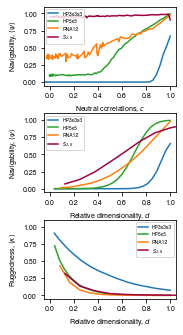

In [6]:
# COMBINED
# fig = plt.figure(1, figsize=(138/25 * .6, 290/25 * .6))
ONE_COL_MM = 890 * 2/3
figsize = (ONE_COL_MM / 250, 290/128 * ONE_COL_MM / 250)

fig = plt.figure(1, figsize=figsize)

# fs = "x-small"
fs = nee_fs
fs = 5
# -------------
# FIG. 3A
ax = fig.add_subplot(311)

# x_el = "rob-freq-ratio_mean"
x_el = "correlations"

for gp_map in sizes.keys():        
    df = dfs_corr[dfs_corr["GP map"]==gp_map]\
    .groupby(x_el)["Fittest_found?"]\
    .agg(["mean", lambda x: x.std(ddof=1)/np.sqrt(len(x))])\
    .reset_index()\
    .sort_values(x_el)\
    .rename(columns={"<lambda_0>":"SE"})
    
    ax.plot(df[x_el], df["mean"], color=colors_map[gp_map], label=labels[gp_map])
        
    extra=1.
    intercept=0.01

ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.1)
ax.set_ylabel(r'Navigability, $\left<\psi\right>$')
ax.set_xlabel(r'Neutral correlations, $c$')

ax.legend(loc="upper left", prop={"size":fs}, frameon=True)

# FIG. 3B

ax = fig.add_subplot(312)

for gp_map in sizes.keys():
    df = dfs_dim[dfs_dim["GP map"]==gp_map]\
    .groupby("dim")["Fittest_found?"]\
    .agg(["mean", lambda x: x.std(ddof=1)/np.sqrt(len(x))])\
    .reset_index()\
    .sort_values("dim")\
    .rename(columns={"<lambda_0>":"SE"})
    
    ax.plot(df["dim"]/lengths[gp_map], df["mean"], color=colors_map[gp_map], label=labels[gp_map])
        
    extra=1.
    intercept=0.01

ax.set_xlim(0, 1.0)
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.1)
ax.set_ylabel(r'Navigability, $\left<\psi\right>$')
ax.set_xlabel(r'Relative dimensionality, $d$')

ax.legend(loc="upper left", prop={"size":fs}, frameon=True)

# FIG. 3B
ax = fig.add_subplot(313)

for gp_map in sizes.keys():
    df = dfs_rug[dfs_rug["GP map"]==gp_map]\
    .groupby("dim")["ruggedness"]\
    .agg(["mean", lambda x: x.std(ddof=1)/np.sqrt(len(x))])\
    .reset_index()\
    .sort_values("dim")\
    .rename(columns={"<lambda_0>":"SE"})
    
    ax.plot(df["dim"]/lengths[gp_map], df["mean"], color=colors_map[gp_map], label=labels[gp_map])
    
    extra=1.
    intercept=0.01
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.1)
ax.set_ylabel(r'Ruggedness, $\left<\kappa\right>$')
ax.set_xlabel(r'Relative dimensionality, $d$')

ax.legend(loc="upper right", prop={"size":fs}, frameon=True)

fig.subplots_adjust(hspace=0.35)

fig.savefig(os.path.join(OUT_PATH, "fig3.pdf"), transparent=True, bbox_inches='tight')

In [7]:
# Calculate minimum and maximum correlations
df_corr_random = None
for gp_map in sizes.keys():        
    df = dfs_corr[dfs_corr["GP map"]==gp_map]\
    .groupby(x_el)["Fittest_found?"]\
    .agg(["mean", lambda x: x.std(ddof=1)/np.sqrt(len(x))])\
    .reset_index()\
    .sort_values(x_el)\
    .rename(columns={"<lambda_0>":"SE"})
    df["GP map"] = gp_map
    df_corr_random = pd.concat([df_corr_random, df], axis=0)

    
df_corr_random["abs_corr"] = df_corr_random["correlations"].abs()

for keep in ["first", "last"]:
    print(
        (
            df_corr_random
            .sort_values(["abs_corr", "GP map"])
            .drop_duplicates(subset=["GP map"], keep=keep)
            .drop(columns=["abs_corr"])
            .round(3)
        ).to_markdown(index=None)
    )

|   correlations |   mean |    SE | GP map   |
|---------------:|-------:|------:|:---------|
|         -0     |  0.1   | 0.003 | HP5x5s   |
|         -0     |  0     | 0     | HP3x3x3s |
|         -0.002 |  0.378 | 0.005 | RNA12    |
|          0.002 |  0.949 | 0.002 | s_2_8    |
|   correlations |   mean |    SE | GP map   |
|---------------:|-------:|------:|:---------|
|              1 |  0.669 | 0.005 | HP3x3x3s |
|              1 |  0.995 | 0.001 | HP5x5s   |
|              1 |  0.967 | 0.002 | RNA12    |
|              1 |  0.904 | 0.003 | s_2_8    |
